# Optimize Location

Optimize object's position and orientation

## 0. Install and import requirements

* torch_psdr: core library
* pytorch (cuda): core dependency library
* pywavefront: read `.obj` format mesh object
* imageio: read image-based texture
* matplotlib: show rendered image in notebook
* pywavefront_uv: load wavefront .obj mesh

⚠️ ATTENTION:

**Please restart notebook kernel after installation!**

**DO NOT run following installation script if you have installed!**

In [ ]:
# torch_psdr is in channel luling. This will install cuda based pytorch automatically
! conda install -y torch_psdr -c luling -c pytorch
# install other dependencies we need to run this example
! conda install -y imageio matplotlab -c conda-forge
# install forked pywavefront
! conda install pywavefront_uv -c luling

In [1]:
%matplotlib inline

import torch_psdr as dr
import random
import math
import torch
import torch.optim
import torch.nn.functional as F
from pywavefront_uv import Wavefront
import imageio.v3 as imageio
from utilities import translate, scale, rotate
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# define some global variables
device = "cuda:0"

/root/miniconda3/envs/psdr-run/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Read mesh objects

Define functions to load scene objects and an spot cow object named `spot` with image-based texture.

In [2]:
def load_obj(obj_path):
  scene = Wavefront(obj_path, create_materials=True, collect_faces=True)
  vertices = torch.tensor(scene.vertices, dtype=torch.float32, device=device)
  uvs = None if scene.parser.tex_coords == [] else torch.tensor(scene.parser.tex_coords, dtype=torch.float32, device=device)
  objs = {}
  for name, mesh in scene.meshes.items():
    if name is None:
      name = str(hash(mesh))
    indices = torch.tensor(mesh.faces, dtype=torch.int32, device=device)
    face_indices = indices[:,:,0]
    uv_indices = indices[:,:,1] if indices[0,0,1] != -1 else None
    material = mesh.materials[0]
    obj = None
    if name == "light":
      emit = torch.tensor(material.ambient[:3], dtype=torch.float32, device=device)
      obj = dr.AreaLight(vertices, face_indices, emit)
    else:
      diffuse = torch.tensor(material.diffuse[:3], dtype=torch.float32, device=device)
      normal = None
      roughness = torch.tensor([0.5], dtype=torch.float32, device=device)
      material = dr.DiffuseBsdfMaterial(diffuse, roughness, normal)
      obj = dr.Mesh(vertices, uvs, face_indices, uv_indices, material)
    objs[name] = obj
  return objs

def load_spot(obj_path, rotate_angle=None, translation=None):
  scene = Wavefront(obj_path, create_materials=True, collect_faces=True)
  vertices = torch.tensor(scene.vertices, dtype=torch.float32, device=device)
  if rotate_angle is not None:
    pitch, yaw, roll = rotate_angle
    vertices = rotate(vertices, pitch, yaw, roll)
  vertices.mul_(150).add_(torch.tensor([400, 200, 300], dtype=torch.float32, device=device))
  if translation is not None:
    vertices.add_(translation)
  uvs = None if scene.parser.tex_coords == [] else torch.tensor(scene.parser.tex_coords, dtype=torch.float32, device=device)
  objs = {}
  for name, mesh in scene.meshes.items():
    if name is None:
      name = str(hash(mesh))
    indices = torch.tensor(mesh.faces, dtype=torch.int32, device=device)
    face_indices = indices[:,:,0]
    uv_indices = indices[:,:,1] if indices[0,0,1] != -1 else None
    material = mesh.materials[0]
    tex = imageio.imread(material.texture.path)
    diffuse_tex = torch.tensor(tex, dtype=torch.float32, device=device) / 255
    normal = None
    roughness = torch.tensor([0.5], dtype=torch.float32, device=device)
    material = dr.DiffuseBsdfMaterial(diffuse_tex, roughness, normal)
    obj = dr.Mesh(vertices, uvs, face_indices, uv_indices, material)
  objs[name] = obj
  return objs

## 2. Set camera

In [3]:
def set_camera():
  look_from = torch.tensor([278, 278, -800], dtype=torch.float32, device=device)
  look_at = torch.tensor([278, 278, 0], dtype=torch.float32, device=device)
  up = torch.tensor([0, 1, 0], dtype=torch.float32, device=device)
  vfov = torch.tensor([torch.deg2rad(torch.tensor(38.0))], dtype=torch.float32, device=device)
  height, width = 256, 256
  camera = dr.PerspectiveCamera(
    look_from = look_from,
    look_at = look_at,
    up = up,
    vfov = vfov,
    height = height,
    width = width,
  )
  return camera

## 3. Configure renderer

In [8]:
def render_img(scene, diff_mode=False, spp=None):
  spp = 32 if spp is None else spp
  integrator = dr.PathIntegrator(
    n_pass=1,
    spp_interior=spp,
    enable_light_visable=False,
    spp_primary_edge=4,
    spp_secondary_edge=2,
    primary_edge_preprocess_rounds=6,
    secondary_edge_preprocess_rounds=6,
    max_bounce=2,
    mis_light_samples=2,
    mis_bsdf_samples=0,
  )
  imgs = integrator.renderD(scene) if diff_mode else integrator.renderC(scene)
  return imgs

## 4. Optimize location and orientation

In [9]:
def render_once(obj_path, spot_path, rotate_angle=None, translation=None, diff_mode=False, spp=None):
  objs = load_obj(obj_path)
  spot = load_spot(spot_path, rotate_angle, translation)
  objs.update(spot)

  lights = [obj for name, obj in objs.items() if name == "light"]
  meshes = [obj for name, obj in objs.items() if name != "light"]

  cameras = [set_camera()]

  scene = dr.Scene(cameras, meshes, lights)

  imgs = render_img(scene, diff_mode, spp)

  return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


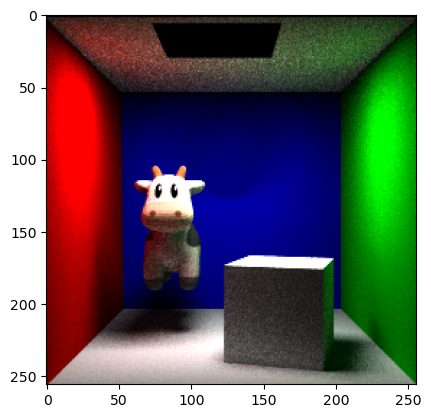

In [10]:
# render target image
obj_path = "../data/input/cornell_box.obj"
spot_path = "../data/input/spot/spot_triangulated.obj"
target_imgs = render_once(obj_path, spot_path, spp=80)
target_img = target_imgs[0].detach().clone()
tgt_img = target_img.detach().cpu().numpy()
plt.imshow(tgt_img)

# collect garbage
target_imgs = None
tgt_img = None
import gc
import enoki as ek
gc.collect()
ek.cuda_malloc_trim()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


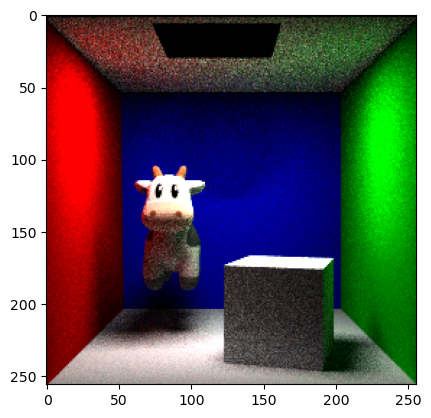

iter: 100, loss: 0.002707079751417041;
 rotate grad: tensor([ 1626404.7500,   772580.3125, -5983740.0000], device='cuda:0'), curr rotate: tensor([-0.1460,  0.2789,  0.1730], device='cuda:0', grad_fn=<Rad2DegBackward>)


iter: 101, loss: 0.0027233720757067204;
 rotate grad: tensor([  526078.2500,   156566.8125, -3045892.7500], device='cuda:0'), curr rotate: tensor([-0.1491,  0.2780,  0.1904], device='cuda:0', grad_fn=<Rad2DegBackward>)


iter: 102, loss: 0.002730398206040263;
 rotate grad: tensor([3316418.5000, 1416612.6250, 7050038.0000], device='cuda:0'), curr rotate: tensor([-0.1681,  0.2699,  0.1500], device='cuda:0', grad_fn=<Rad2DegBackward>)


iter: 103, loss: 0.00271397246979177;
 rotate grad: tensor([-1599320.7500, -2094032.8750, -1272973.0000], device='cuda:0'), curr rotate: tensor([-0.1589,  0.2819,  0.1573], device='cuda:0', grad_fn=<Rad2DegBackward>)


iter: 104, loss: 0.0027183860074728727;
 rotate grad: tensor([-6828703.5000,   860775.8750,  4733577.0000], device='cuda:0'

KeyboardInterrupt: 

: 

In [18]:
# init_rotate = torch.deg2rad(torch.rand((3,), dtype=torch.float32, device=device) * 40 - 20)
init_rotate = torch.deg2rad(torch.tensor([20, 20, 20], dtype=torch.float32, device=device))
rotate_param = torch.tensor(init_rotate.clone().detach(), dtype=torch.float32, device=device, requires_grad=True)

# set optimizer
lr = 1e-10
parameters = [
  {"params": rotate_param, "lr": lr},
]
optim = torch.optim.SGD(parameters, lr=lr)

# optimize
iterations = 100
for iter in range(iterations):
  (pitch, yaw, roll) = rotate_param[0], rotate_param[1], rotate_param[2]
  imgs = render_once(obj_path, spot_path, (pitch, yaw, roll), diff_mode=True)
  img = imgs[0]
  loss = F.mse_loss(imgs[0], target_img)
  loss.backward()
  optim.step()
  print(f"iter: {iter}, loss: {loss};\n rotate grad: {rotate_param.grad}, curr rotate: {torch.rad2deg(rotate_param)}\n\n")
  optim.zero_grad()
  if iter%10 == 9:
    clear_output()
    img = img.detach().cpu().numpy()
    plt.imshow(img)
    plt.show()


In [ ]:
print(parameters)

# 200 iters OK